In [1]:
import sys
import os
import numpy as np
import pygod
from pygod.utils import load_data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
import torch_sparse
from torch_sparse import SparseTensor
from typing import List
from sklearn.metrics import roc_auc_score
from gad_adversarial_robustness.utils.graph_utils import prepare_graph, get_n_anomaly_indexes, load_anomaly_detection_dataset
from gad_adversarial_robustness.poison.greedy import multiple_AS, poison_attack

import argparse
import scipy.sparse as sp
from scipy.sparse import coo_matrix
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils import to_undirected

# --------- related to dataset import
from pygod.generator import gen_contextual_outlier, gen_structural_outlier
from torch_geometric.datasets import AttributedGraphDataset

# --------- jaccard
from gad_adversarial_robustness.gad.dominant.dominant_cuda import Dominant
from gad_adversarial_robustness.gad.dominant.dominant_cuda_Jaccard_similarity import Dominant as DominantJaccard

# --------- setup
import yaml

In [2]:
NUM_CLASSES = 2
PRELOADED_EDGE_INDEX = True
EDGE_INDEX_PT = "100_budget_facebook_greedy_edge_index.pt"

#### Import Data

In [3]:
# ------- datasets: 
data_name = ["Cora", "Wiki", "Facebook", "Blogcatalog"] # blogcataog not an option yet
string = data_name[2]

dataset = AttributedGraphDataset(root = "data/"+string, name = string)
data = dataset[0]

data.edge_index = to_undirected(data.edge_index)

clean_data = data.clone() # save for later use

# ------- inject dataset through pygod:
seed = None
num_nodes_to_inject = 20
num_nodes_per_clique = 10
num_cliques = (num_nodes_to_inject // 2) // num_nodes_per_clique
num_contextual_outliers = num_nodes_to_inject - num_cliques * num_nodes_per_clique

data, ya = gen_contextual_outlier(data, n = num_contextual_outliers, k = 50, seed = seed) 
#   n (int) – Number of nodes converting to outliers.
#   k (int) – Number of candidate nodes for each outlier node.

data, ys = gen_structural_outlier(data, m = num_nodes_per_clique, n = num_cliques, seed = seed)
#   m (int) - Number nodes in the outlier cliques.
#   n (int) - Number of outlier clique

data.y = torch.logical_or(ys, ya).long() # where ys = y structural and ya = y attribute

y_binary: List[int] = data.y.bool()
anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide

In [4]:
print('poisoned data:   ', data)
print('clean data:      ', clean_data)
print('edge_index diff: ', len(data.edge_index[1]) - len(clean_data.edge_index[1]))

poisoned data:    Data(x=[4039, 1283], edge_index=[2, 176558], y=[4039])
clean data:       Data(x=[4039, 1283], edge_index=[2, 176468], y=[4039, 193])
edge_index diff:  90


#### adj matrix from edge_index

In [5]:
# -----> to obtain the adj matrix from edge_index tensor 
_, adj, _ = prepare_graph(data)

data.adj = adj.to_dense()

tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 4038, 4038, 4038]),
             col=tensor([   1,    2,    3,  ..., 4023, 4027, 4031]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(4039, 4039), nnz=176556, density=1.08%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])


### Posion (compute OR load in poisoned data)

In [6]:

if PRELOADED_EDGE_INDEX is False :
    # truth, of type int list, is instantiated to the T/F labels indicating whether a node is an anomalous node
    truth: List[int] = data.y.bool()
    print('truth: ', truth)

    A = np.array(data.adj)

    print("Create poison compatible adjacency matrix...") # based on code from: https://github.com/zhuyulin-tony/BinarizedAttack/blob/main/src/Greedy.py
    triple = []
    for i in range(data.num_nodes): # for all nodes...
        for j in range(i + 1, data.num_nodes):
            triple.append([i, j, A[i,j]])  # Fill with 0, then insert actual after
    triple = np.array(triple) # convert to numpy array

    print('tripple: ', triple)

    # ------- Identify Anomalous Nodes 
    # The nodes we try reduce the "Active Subnetwork" score for (i.e. disguise anonomalous nodes)
    target_node_lst = get_n_anomaly_indexes(truth, 999) # the indexes of the anomalies (999 is just a flag, if not 999 then it gets from 0 to n anomaly indexes)

    # ------- Making Model
    model = multiple_AS(target_lst = target_node_lst, n_node = data.num_nodes, device = 'cpu')
    budget = 1  # The amount of edges to change

    # ------- Attack (GradMaxSearch, i.e. the greedy attack)
    adj_adversary, _, _ = poison_attack(model, triple, budget) # returns modified/ poisoned adj matrix

    # -------- post-attack processing --> i.e. "Converting to compatible tensor"
    edge_index = torch.tensor([[],[]]) # Create new Edge Index

    # Transpose it to make shape compatible
    transposed_adj_adversary = torch.transpose(adj_adversary, 0, 1)

    for i in range(len(adj_adversary)):
        if(adj_adversary[i][2] != 0):   # If edge value is NOT 0 (0 meaning no edge)
            # Add edge to edge index, choosing first 2 elements (edges), and then the ith edge
            edge_index = torch.cat((edge_index, transposed_adj_adversary[:2, i:i+1]), -1)

            # Dataset uses edges both ways so add reverse edge as well
            edge_index = torch.cat((edge_index, torch.flip(transposed_adj_adversary[:2, i:i+1], dims=[0])), -1)

    edge_index = edge_index.type(torch.int64)
    data.edge_index = edge_index # assign to dataset obj

    # ---- SAVE the edge index data: 
    torch.save(data.edge_index, '100_budget_facebook_greedy_edge_index.pt')
else :
    # load data
    data.edge_index = torch.load(EDGE_INDEX_PT)


In [7]:
print('poisoned data:   ', data)
print('clean data:      ', clean_data)
print('edge_index diff: ', len(data.edge_index[1]) - len(clean_data.edge_index[1]))

poisoned data:    Data(x=[4039, 1283], edge_index=[2, 176556], y=[4039], adj=[4039, 4039])
clean data:       Data(x=[4039, 1283], edge_index=[2, 176468], y=[4039, 193])
edge_index diff:  88


# GAD: DOMINANT JACCARD SIMILARITY

In [8]:
script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..', 'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

In [9]:
#### DELETE CELL AFTER DEBUGGING --> move changes to utils #####
from gad_adversarial_robustness.utils.graph_utils import to_dense_adj, normalize_adj
def load_anomaly_detection_dataset(dataset, datadir='data'):
    # import dataset and extract its parts
    #dataset = load_data("inj_cora")
    edge_index = dataset.edge_index
    adj = to_dense_adj(edge_index)[0].detach().cpu().numpy() # size of adj = 16313521
    print('adj size after to_dense_adj call: ', adj.size)
    
    feat= dataset.x.detach().cpu().numpy()
    # remember to use .bool() if the dataset is an injected dataset, to enable binary labels.
    # TODO: handle the case where we inject ourselves
    print('dataset.y.size : ', len(dataset.y)) # 4039
    print('detached y: ', len(dataset.y.bool().detach().cpu().numpy())) # 4039

    truth = dataset.y.bool().detach().cpu().numpy()
    # truth = truth.flatten() # len: 779527
    

    adj_norm = normalize_adj(adj + sp.eye(adj.shape[0]))
    adj_norm = adj_norm.toarray()
    adj = adj + np.eye(adj.shape[0])
    return adj_norm, feat, truth, adj

### regular Dominant on CLEAN and POISONED data

In [10]:
print("DOMINANT on CLEAN data:")
adj, attrs, label, adj_label = load_anomaly_detection_dataset(clean_data)
edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label)
attrs = torch.FloatTensor(attrs)

model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                    device='cpu', edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label)

model.fit(config, verbose=True)

# retrieve stats
M1_feature_loss_arr = model.feature_loss_arr
M1_structure_loss_arr = model.structure_loss_arr

M1_loss_arr = model.loss_arr

M1_aucroc_arr = model.aucroc_arr
M1_aucroc_norm = model.aucroc_norm_arr

DOMINANT on CLEAN data:
adj size after to_dense_adj call:  16313521
dataset.y.size :  4039
detached y:  4039
Epoch: 0000, train_loss=3.72521, train/struct_loss=6.06042, train/feat_loss=2.72440
Epoch: 0000, roc-auc: 0.7224373293621247
Top 10 highest anomaly scores' node IDs and scores:
Epoch: 0001, train_loss=3.63771, train/struct_loss=5.81414, train/feat_loss=2.70495
Epoch: 0002, train_loss=3.77394, train/struct_loss=6.36388, train/feat_loss=2.66396
Epoch: 0003, train_loss=3.59375, train/struct_loss=5.80327, train/feat_loss=2.64681
Epoch: 0004, train_loss=3.58340, train/struct_loss=5.82378, train/feat_loss=2.62324
Epoch: 0005, train_loss=3.55825, train/struct_loss=5.81284, train/feat_loss=2.59199
Epoch: 0006, train_loss=3.53241, train/struct_loss=5.82204, train/feat_loss=2.55114
Epoch: 0007, train_loss=3.49391, train/struct_loss=5.79322, train/feat_loss=2.50849
Epoch: 0008, train_loss=3.44752, train/struct_loss=5.74286, train/feat_loss=2.46380
Epoch: 0009, train_loss=3.40171, train/str

In [11]:
print("DOMINANT on POISONED data:")
dataset = data
adj, attrs, label, adj_label = load_anomaly_detection_dataset(dataset)
edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label)
attrs = torch.FloatTensor(attrs)

model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                    device='cpu', edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label)

model.fit(config, verbose = True)

# retrieve stats
M2_feature_loss_arr = model.feature_loss_arr
M2_structure_loss_arr = model.structure_loss_arr

M2_loss_arr = model.loss_arr

M2_aucroc_arr = model.aucroc_arr
M2_aucroc_norm = model.aucroc_norm_arr

DOMINANT on POISONED data:
adj size after to_dense_adj call:  16313521
dataset.y.size :  4039
detached y:  4039
Epoch: 0000, train_loss=3.68670, train/struct_loss=5.90775, train/feat_loss=2.73483
Epoch: 0000, roc-auc: 0.6507464543418762
Top 10 highest anomaly scores' node IDs and scores:
Epoch: 0001, train_loss=3.65271, train/struct_loss=5.85072, train/feat_loss=2.71070
Epoch: 0002, train_loss=3.63319, train/struct_loss=5.83387, train/feat_loss=2.69004
Epoch: 0003, train_loss=3.60541, train/struct_loss=5.81531, train/feat_loss=2.65831
Epoch: 0004, train_loss=3.58252, train/struct_loss=5.84775, train/feat_loss=2.61171
Epoch: 0005, train_loss=3.52795, train/struct_loss=5.76983, train/feat_loss=2.56715
Epoch: 0006, train_loss=3.47902, train/struct_loss=5.73331, train/feat_loss=2.51290
Epoch: 0007, train_loss=3.42566, train/struct_loss=5.68861, train/feat_loss=2.45582
Epoch: 0008, train_loss=3.36978, train/struct_loss=5.60092, train/feat_loss=2.41358
Epoch: 0009, train_loss=3.34093, train/

### Dominant Jaccard Similarity on poisoned data

In [12]:
jaccard_threshold = 0.01

print("DOMINANT modified w/ Jaccard on CLEAN data:")
adj, _, _, adj_label = load_anomaly_detection_dataset(clean_data, config['model']['device'])

#edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
#attrs = torch.FloatTensor(attrs)

edge_index = clean_data.edge_index.to(config['model']['device'])
label = torch.Tensor(clean_data.y.bool()).to(config['model']['device'])
attrs = clean_data.x.to(config['model']['device'])

model = DominantJaccard(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                    device=config['model']['device'], edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label, adj=adj)
model.to(config['model']['device'])
model.fit(config, threshold=jaccard_threshold, verbose=True)

# retrieve stats
M3_feature_loss_arr = model.feature_loss_arr
M3_structure_loss_arr = model.structure_loss_arr

M3_loss_arr = model.loss_arr

M3_aucroc_arr = model.aucroc_arr
M3_aucroc_norm = model.aucroc_norm_arr

DOMINANT modified w/ Jaccard on CLEAN data:
adj size after to_dense_adj call:  16313521
dataset.y.size :  4039
detached y:  4039
count of avoided zero division: ------------------------------- 8
removed 2087 edges in the original graph


d:\karenscode\dat6_gad\aau-dat6-poison-gad\gad_adversarial_robustness\gad\GCN_Jaccard.py:356: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(sparseconcat.t(),sparsedata,torch.Size(sparse_mx.shape))
d:\karenscode\dat6_gad\aau-dat6-poison-gad\gad_adversarial_robustness\gad\GCN_Jaccard.py:390: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1/2).flatten()


Epoch: 0000, train_loss=3.69196, train/struct_loss=5.94477, train/feat_loss=2.72646
Epoch: 0000, roc-auc: 0.7221394887068752
Top 10 highest anomaly scores' node IDs and scores:
Epoch: 0001, train_loss=3.64696, train/struct_loss=5.83410, train/feat_loss=2.70961
Epoch: 0002, train_loss=3.64723, train/struct_loss=5.90650, train/feat_loss=2.67897
Epoch: 0003, train_loss=3.59320, train/struct_loss=5.80838, train/feat_loss=2.64383
Epoch: 0004, train_loss=3.56048, train/struct_loss=5.80469, train/feat_loss=2.59867
Epoch: 0005, train_loss=3.52226, train/struct_loss=5.80812, train/feat_loss=2.54261
Epoch: 0006, train_loss=3.47463, train/struct_loss=5.77420, train/feat_loss=2.48909
Epoch: 0007, train_loss=3.42472, train/struct_loss=5.73519, train/feat_loss=2.43452
Epoch: 0008, train_loss=3.38022, train/struct_loss=5.69239, train/feat_loss=2.38929
Epoch: 0009, train_loss=3.35367, train/struct_loss=5.64609, train/feat_loss=2.37121
Epoch: 0010, train_loss=3.33949, train/struct_loss=5.59308, train/f

In [13]:
print("DOMINANT modified w/ Jaccard on POISONED data:")
dataset = data
adj, _, _, adj_label = load_anomaly_detection_dataset(dataset, config['model']['device'])
#edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
#attrs = torch.FloatTensor(attrs)

edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])

model = DominantJaccard(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                    device=config['model']['device'], edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label, adj=adj)
model.to(config['model']['device'])
model.fit(config, threshold=jaccard_threshold, verbose=True)

# retrieve stats
M4_feature_loss_arr = model.feature_loss_arr
M4_structure_loss_arr = model.structure_loss_arr

M4_loss_arr = model.loss_arr

M4_aucroc_arr = model.aucroc_arr
M4_aucroc_norm = model.aucroc_norm_arr

DOMINANT modified w/ Jaccard on POISONED data:
adj size after to_dense_adj call:  16313521
dataset.y.size :  4039
detached y:  4039
count of avoided zero division: ------------------------------- 8
removed 2081 edges in the original graph


d:\karenscode\dat6_gad\aau-dat6-poison-gad\gad_adversarial_robustness\gad\GCN_Jaccard.py:390: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1/2).flatten()


Epoch: 0000, train_loss=3.68571, train/struct_loss=5.90549, train/feat_loss=2.73437
Epoch: 0000, roc-auc: 0.6484946504105499
Top 10 highest anomaly scores' node IDs and scores:
Epoch: 0001, train_loss=3.64906, train/struct_loss=5.82057, train/feat_loss=2.71841
Epoch: 0002, train_loss=3.78654, train/struct_loss=6.34077, train/feat_loss=2.69186
Epoch: 0003, train_loss=3.61074, train/struct_loss=5.80834, train/feat_loss=2.66891
Epoch: 0004, train_loss=3.59148, train/struct_loss=5.81847, train/feat_loss=2.63705
Epoch: 0005, train_loss=3.56090, train/struct_loss=5.80997, train/feat_loss=2.59701
Epoch: 0006, train_loss=3.52921, train/struct_loss=5.81321, train/feat_loss=2.55035
Epoch: 0007, train_loss=3.48738, train/struct_loss=5.78694, train/feat_loss=2.50186
Epoch: 0008, train_loss=3.44435, train/struct_loss=5.76514, train/feat_loss=2.44972
Epoch: 0009, train_loss=3.40529, train/struct_loss=5.73853, train/feat_loss=2.40534
Epoch: 0010, train_loss=3.38268, train/struct_loss=5.70422, train/f

In [14]:
M4_aucroc_arr


[0.6484946504105499,
 0.6389151530231401,
 0.6756780293605376,
 0.6912540432943519,
 0.6812639960189102,
 0.6832172182134859,
 0.6832669818362777,
 0.6767603881562576,
 0.6669196317491912,
 0.6648046777805423,
 0.6675292361283901]

## Plotting 

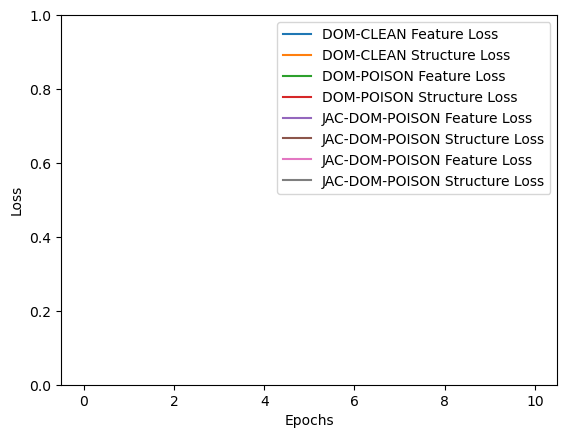

In [33]:
import matplotlib.pyplot as plt
# subplot 1: development of the structure loss and feature loss over the number of epochs

plt.plot(M1_feature_loss_arr, label='DOM-CLEAN Feature Loss')
plt.plot(M1_structure_loss_arr, label='DOM-CLEAN Structure Loss')

plt.plot(M2_feature_loss_arr, label='DOM-POISON Feature Loss')
plt.plot(M2_structure_loss_arr, label='DOM-POISON Structure Loss')

plt.plot(M3_feature_loss_arr, label='JAC-DOM-POISON Feature Loss')
plt.plot(M3_structure_loss_arr, label='JAC-DOM-POISON Structure Loss')

plt.plot(M4_feature_loss_arr, label='JAC-DOM-POISON Feature Loss')
plt.plot(M4_structure_loss_arr, label='JAC-DOM-POISON Structure Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


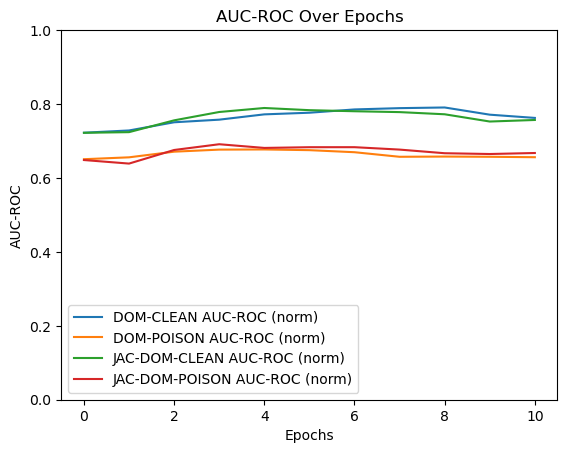

In [34]:
# subplot 2: the second subplot shows the development of the AUC-ROC value over the number of epochs (NORMALIZED AUC-ROC Score)

# Plot the AUC-ROC score
plt.plot(M1_aucroc_norm, label='DOM-CLEAN AUC-ROC (norm)')
plt.plot(M2_aucroc_norm, label='DOM-POISON AUC-ROC (norm)')
plt.plot(M3_aucroc_norm, label='JAC-DOM-CLEAN AUC-ROC (norm)')
plt.plot(M4_aucroc_norm, label='JAC-DOM-POISON AUC-ROC (norm)')
plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC Over Epochs')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.legend()
plt.show()

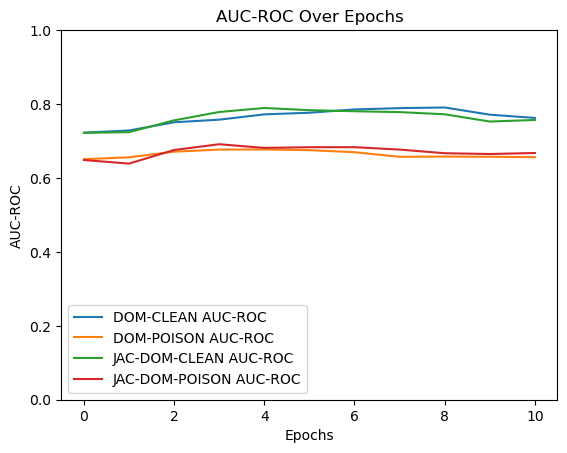

In [35]:
# subplot 3: the second subplot shows the development of the AUC-ROC value over the number of epochs (NOT-NORMALIZED AUC-ROC Score)

# Plot the AUC-ROC score
plt.plot(M1_aucroc_arr, label='DOM-CLEAN AUC-ROC')
plt.plot(M2_aucroc_arr, label='DOM-POISON AUC-ROC')
plt.plot(M3_aucroc_arr, label='JAC-DOM-CLEAN AUC-ROC')
plt.plot(M4_aucroc_arr, label='JAC-DOM-POISON AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC Over Epochs')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.legend()
plt.show()

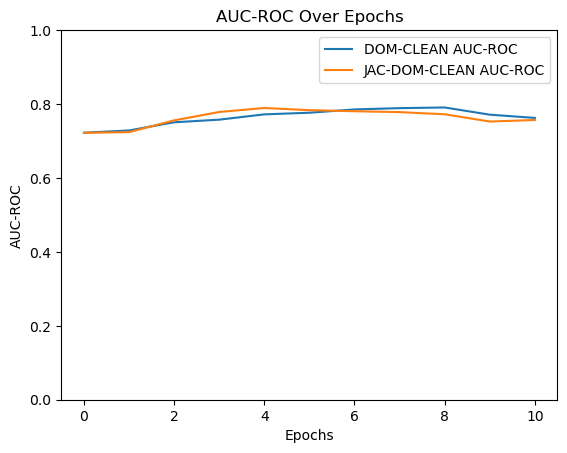

In [32]:

plt.plot(M1_aucroc_arr, label='DOM-CLEAN AUC-ROC')
plt.plot(M3_aucroc_arr, label='JAC-DOM-CLEAN AUC-ROC')
# plt.plot(M1_aucroc_norm, label='DOM-CLEAN AUC-ROC (norm)')
# plt.plot(M3_aucroc_norm, label='JAC-DOM-CLEAN AUC-ROC (norm)')
plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC Over Epochs')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1

plt.legend()
plt.show()

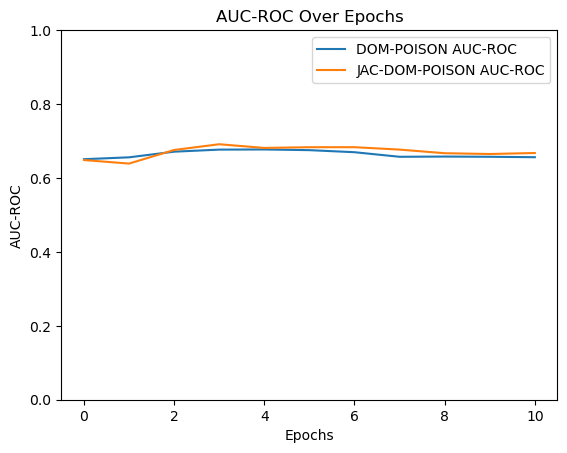

In [29]:

plt.plot(M2_aucroc_arr, label='DOM-POISON AUC-ROC')
plt.plot(M4_aucroc_arr, label='JAC-DOM-POISON AUC-ROC')

# plt.plot(M2_aucroc_norm, label='DOM-POISON AUC-ROC (norm)')
# plt.plot(M4_aucroc_norm, label='JAC-DOM-POISON AUC-ROC (norm)')

plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC Over Epochs')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.legend()
plt.show()

In [18]:
# # make a train/validation/test split #
# labels = data.y

# # ----------- create new masks with specified split 
# split = [0.6, 0.2, 0.2]
# train_ratio = split[0]
# val_ratio = split[1]
# test_ratio = split[2]

# # Create a random permutation of node indices
# node_indices = torch.randperm(num_nodes)
# print(node_indices)

# # Calculate the split indices
# train_size = int(num_nodes * train_ratio)
# val_size = int(num_nodes * val_ratio)
# test_size = num_nodes - train_size - val_size

#     # Create new masks based on the split indices
# new_train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# new_train_mask[node_indices[:train_size]] = True

# new_val_mask = torch.zeros(num_nodes, dtype=torch.bool)
# new_val_mask[node_indices[train_size:train_size+val_size]] = True

# new_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
# new_test_mask[node_indices[train_size+val_size:]] = True

# # Assign the new masks to the data object
# data.train_mask = new_train_mask
# data.val_mask = new_val_mask
# data.test_mask = new_test_mask

# # Extract the new indices for the training, validation, and test sets
# idx_train = np.where(data.train_mask == True)[0]
# idx_val = np.where(data.val_mask == True)[0]
# idx_test = np.where(data.test_mask == True)[0]

# # from the RTGNN github ----------------------------------------------
# train_labels = labels[idx_train]
# val_labels = labels[idx_val]

# # Concatenating training and validation labels
# train_val_labels = np.concatenate([train_labels, val_labels],axis=0)

# # Concatenating training and validation masks
# idx = np.concatenate([idx_train, idx_val],axis=0)


# # # convert the T/F labels to integers --> used in the following call of "noisyfy_with_P"
# train_val_labels_int = train_val_labels.astype(int)
# # idx_int = idx.astype(int)